## Examine the elasticity of the residential location choice model

In [ ]:
# Load data
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import Config, get_elasticity, get_cross_elasticity, find_neighbors, find_k_hop_neighbors
from models import MNL_Choice, SCL_Choice, GNNChoiceModel, MLP_Choice
from data_process import load_data, spatial_choice_dataset_interact
import geopandas as gd
from shapely.ops import unary_union
comm, hh, edge_index, distance_to_work = load_data()

comm_features = [
    "pop_density",
    "white_prop",
    "black_prop",
    "single_res",
    "multi_res",
    "office",
    "land_mix",
    "transit_a_scaled",
    "med_house_age_scaled",
    "med_value_scaled",
    "h_units_scaled",
    "median_inc_scaled",
]


hh_features = ["hh_income_scaled", "race_white", "race_black"]

# Load dataset
my_dataset = spatial_choice_dataset_interact

i = 0
test_idx = np.arange(i, len(hh), 10)
train_idx = np.setdiff1d(np.arange(len(hh)), test_idx)
train_dataset = my_dataset(
    comm, hh.loc[train_idx, :], distance_to_work[train_idx], comm_features, hh_features
)
test_dataset = my_dataset(
    comm, hh.loc[test_idx, :], distance_to_work[test_idx], comm_features, hh_features
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=len(train_dataset), shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False
)

In [30]:
# Load GNN model
device = torch.device("cpu")
config = Config()
config.bs = 32
config.num_hidden = 64
config.dropout = 0
config.model = "GATConv"
config.heads = 4  # Number of attention heads for GAT
config.residual = True
config.seed = 100

gnn1 = GNNChoiceModel(
    train_dataset[0][0].shape[-1],
    config.num_hidden,
    edge_index,
    dropout=config.dropout,
    heads=config.heads,
    residual=config.residual,
    n_layer=1,
)
gnn1.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-03-16_11-38-29.pth"))
# gnn1.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-03-16_11-40-30.pth"))

gnn2 = GNNChoiceModel(
    train_dataset[0][0].shape[-1],
    config.num_hidden,
    edge_index,
    dropout=config.dropout,
    heads=config.heads,
    residual=config.residual,
    n_layer=2,
)
gnn2.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-03-16_11-43-35.pth"))
# gnn2.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-03-16_11-48-31.pth"))

gnn3 = GNNChoiceModel(
    train_dataset[0][0].shape[-1],
    config.num_hidden,
    edge_index,
    dropout=config.dropout,
    heads=config.heads,
    residual=config.residual,
    n_layer=3,
)
gnn3.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-03-16_11-56-03.pth"))
# gnn3.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-03-16_12-03-48.pth"))

# Load MLP model
config.num_hidden = 64
config.model = "MLP"
mlp = MLP_Choice(train_dataset[0][0].shape[-1], config.num_hidden, config.dropout)
mlp.load_state_dict(torch.load("log/Deepchoice_MLP_2025-03-16_12-15-37.pth"))

# Load MNL model
mnl = MNL_Choice(train_dataset[0][0].shape[-1],
                    train_dataset[0][0].shape[0]).to(device)
mnl.load_state_dict(torch.load("log/Deepchoice_MNL_2025-03-16_12-17-54.pth"))

# Load MNL model
# Load all MNL models in the log folder (name contain MNL), and print the beta values
# import os
# file_list = os.listdir("log")
# mnl_files = [file for file in file_list if "MNL" in file]
# param_dict = {}
# for file in mnl_files:
#     mnl = MNL_Choice(train_dataset[0][0].shape[-1], train_dataset[0][0].shape[0]).to(device)
#     mnl.load_state_dict(torch.load("log/" + file))
#     print(file)
#     print({name: param for name, param in zip(train_dataset.feature_names, mnl.beta.to(device).detach().numpy().tolist())})
#     param_dict[file] = {name: param for name, param in zip(train_dataset.feature_names, mnl.beta.to(device).detach().numpy().tolist())}
#     print("----------")

/var/folders/v6/5jphmjb1409bj0_xw7mj_7dc0000gn/T/ipykernel_10358/1629312439.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gnn1.load_state_dict(torch.load("log/Deepcho

<All keys matched successfully>

## Calculate the Elasticity

In [ ]:
# Calculate the elasticities of the models
n = 349  # The index of an individual in the test data
i = 5  # The index of the alternative in the choice set
x = test_dataset[n][0]
elasticity_dict = {}
elasticity_dict['GNN'] = get_elasticity(gnn2, x, i).detach().numpy()
elasticity_dict['MLP'] = get_elasticity(mlp, x, i).detach().numpy()
elasticity_dict['MNL'] = get_elasticity(mnl, x, i).detach().numpy()
elasticity = pd.DataFrame(elasticity_dict, index=train_dataset.feature_names)
elasticity.loc[['pop_density', 'white_prop', 'black_prop', 'single_res', 'multi_res', 'office', 'land_mix', 'transit_a_scaled', 'med_house_age_scaled', 'med_value_scaled', 'h_units_scaled', 'median_inc_scaled'], :].T.plot.bar()


,GNN,MLP,MNL
pop_density,0.411045,0.407301,1.858865
single_res,0.002279,-0.016619,-0.056998
multi_res,0.249700,-0.050014,0.116876
office,-0.004368,-0.008650,0.000132
land_mix,-0.145903,0.296730,-0.402896
transit_a_scaled,0.098267,0.500896,-0.909578
med_house_age_scaled,0.856445,1.422490,0.611496
med_value_scaled,-0.648323,-1.645671,-0.148892
h_units_scaled,0.609302,0.509920,1.113971
distance_to_work,-0.289902,-0.185408,-0.190742


In [109]:
ordered_features = [
    "h_units_scaled",
    "med_value_scaled",
    "med_house_age_scaled",
    "land_mix",
    "single_res",
    "multi_res",
    "office",
    "transit_a_scaled",
    "distance_to_work",
    "pop_density",
    "black_interact",
    "white_interact",
    "home_income_interact"]

elasticity.loc[ordered_features, :]

,GNN,MLP,MNL
h_units_scaled,0.609302,0.509920,1.113971
med_value_scaled,-0.648323,-1.645671,-0.148892
med_house_age_scaled,0.856445,1.422490,0.611496
land_mix,-0.145903,0.296730,-0.402896
single_res,0.002279,-0.016619,-0.056998
multi_res,0.249700,-0.050014,0.116876
office,-0.004368,-0.008650,0.000132
transit_a_scaled,0.098267,0.500896,-0.909578
distance_to_work,-0.289902,-0.185408,-0.190742
pop_density,0.411045,0.407301,1.858865


In [111]:
elasticity.loc[ordered_features, :].to_clipboard()

## Calculate the cross-elasticities

In [112]:
# Calculate the cross-elasticities of the models
n = 349  # The index of an individual in the test data
i = [2, 4, 6, 27, 60]  # The index of the alternative in the choice set
j = 5
x = test_dataset[n][0]
elasticity_results = {}

for ii in i:
    elasticity_dict = {}
    elasticity_dict["GNN"] = get_cross_elasticity(gnn2, x, ii, j).detach().numpy()
    elasticity_dict["MLP"] = get_cross_elasticity(mlp, x, ii, j).detach().numpy()
    elasticity_dict["MNL"] = get_cross_elasticity(mnl, x, ii, j).detach().numpy()
    elasticity_results[ii] = pd.DataFrame(elasticity_dict, index=train_dataset.feature_names)

In [117]:
print(elasticity_results[2].loc[ordered_features, :])
elasticity_results[2].loc[ordered_features, :].to_clipboard()

                           GNN       MLP       MNL
h_units_scaled       -0.391552 -0.240099 -0.629841
med_value_scaled      0.333431  0.774875  0.084184
med_house_age_scaled -0.449992 -0.669789 -0.345741
land_mix             -0.016914 -0.139717  0.227798
single_res           -0.004133  0.007825  0.032227
multi_res            -0.141789  0.023549 -0.066082
office                0.001174  0.004073 -0.000075
transit_a_scaled     -0.129869 -0.235850  0.514277
distance_to_work      0.274955  0.087300  0.107846
pop_density          -0.074456 -0.191780 -1.051005
black_interact       -0.000000 -0.000000 -0.000000
white_interact       -0.189093 -0.662576 -0.871916
home_income_interact -0.011428 -0.046410 -0.091406


In [118]:
print(elasticity_results[60].loc[ordered_features, :])
elasticity_results[60].loc[ordered_features, :].to_clipboard()


                           GNN       MLP       MNL
h_units_scaled       -0.244210 -0.240099 -0.629841
med_value_scaled      0.320590  0.774875  0.084184
med_house_age_scaled -0.389357 -0.669789 -0.345741
land_mix              0.120838 -0.139717  0.227798
single_res            0.000397  0.007825  0.032227
multi_res            -0.110004  0.023549 -0.066082
office                0.002686  0.004073 -0.000075
transit_a_scaled     -0.010658 -0.235850  0.514277
distance_to_work      0.088296  0.087300  0.107846
pop_density          -0.210457 -0.191780 -1.051005
black_interact       -0.000000 -0.000000 -0.000000
white_interact       -0.413307 -0.662576 -0.871916
home_income_interact -0.093913 -0.046410 -0.091406


In [8]:
elasticity_results[6]

,GNN,MNL
pop_density,-0.224868,-0.476567
single_res,-0.020056,0.014613
multi_res,-0.001363,-0.029964
office,-0.000606,-0.000034
land_mix,-0.008240,0.103293
transit_a_scaled,-0.025109,0.233194
med_house_age_scaled,-0.094058,-0.156772
med_value_scaled,0.015377,0.038172
h_units_scaled,0.013594,-0.285595
distance_to_work,-0.019250,0.198864


In [9]:
elasticity_results[27]

,GNN,MNL
pop_density,-0.124954,-0.476567
single_res,-0.001285,0.014613
multi_res,-0.036244,-0.029964
office,0.000485,-0.000034
land_mix,0.030950,0.103293
transit_a_scaled,0.001232,0.233194
med_house_age_scaled,-0.090110,-0.156772
med_value_scaled,0.087496,0.038172
h_units_scaled,-0.068781,-0.285595
distance_to_work,0.001298,0.198864


In [11]:
elasticity_results[60]

,GNN,MNL
pop_density,-0.124954,-0.476567
single_res,-0.001285,0.014613
multi_res,-0.036244,-0.029964
office,0.000485,-0.000034
land_mix,0.030950,0.103293
transit_a_scaled,0.001232,0.233194
med_house_age_scaled,-0.090110,-0.156772
med_value_scaled,0.087496,0.038172
h_units_scaled,-0.068781,-0.285595
distance_to_work,0.001298,0.198864


## Visualize the percentage change

In [ ]:
def plot_elasticity(model, comm_id, hh_id, percent_change, feature, vmax=None, vmin=None, boundary=None, alpha=0.8, cmap="RdBu"):
    feature_idx = train_dataset.feature_names.index(feature)
    x = test_dataset[hh_id][0].unsqueeze(0)
    p_old = model(x).exp().detach().numpy()

    x_new = x.clone()
    x_new[0, comm_id, feature_idx] = x_new[0, comm_id, feature_idx] * (1 + percent_change)
    p_new = model(x_new).exp().detach().numpy()
    p_change = (p_new - p_old) / p_old
    comm.loc[:, 'p_change'] = p_change.ravel()

    fig, ax = plt.subplots(figsize=(4, 5))
    if vmax is None and vmin is None:
        vmax = np.abs(comm["p_change"]).max()
        vmin = np.abs(comm["p_change"]).min()
        vmax = max(abs(vmax), abs(vmin))
        vmin = -vmax

    a = comm.plot(
        ax=ax,
        column="p_change",
        cmap=cmap,
        edgecolor="Gray",
        linewidth=0.5,
        legend=False,
        k=8,
        vmin=vmin / 100,
        vmax=vmax / 100,
        alpha=alpha,
    )

    if boundary is not None:
        # Plot the boundary of the k-hop neighbors in dotted line
        boundary.boundary.plot(ax=ax, color="seagreen", linewidth=1.5, facecolor="none", linestyle="--")

    for idx, row in comm.iterrows():
        centroid = row.geometry.centroid
        label = "{:.2f}".format(comm.at[idx, "p_change"]*100)
        # add text as percentage
        plt.text(centroid.x, centroid.y, label, fontsize=5, ha="center", va="center")

    # Create colorbar with the inset axes
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Create colorbar with specific position and size
    cax = inset_axes(
        ax,
        width="3%",  # Width of colorbar as a percentage of ax width
        height="30%",  # Height of colorbar as a percentage of ax height
        loc="lower left",  # Position of the colorbar within ax
        borderpad=1,  # Padding around colorbar
    )
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cax,
        orientation="vertical",
        extend="both",
    )
    cbar.set_label("Percentage change", fontsize=8)  # Optional label for the colorbar
    cbar.ax.set_yticks(
        np.linspace(vmin, vmax, 5)
    )  # Set colorbar ticks
    cbar.ax.tick_params(labelsize=8)  # Adjust colorbar tick font size
    cbar.ax.set_title("%   ", fontsize=8)  # Optional title for the colorbar


    # Remove all axes
    ax.axis("off")
    fig.tight_layout()
    return fig

def get_boundary(node, k):
    """
    Get the boundary of the k-hop neighbors of a node in a graph.
    """
    # find the k hop neighbors of node 5 and get the periphery of the polygon
    nodes = find_k_hop_neighbors(edge_index, node, k)
    nodes.append(5)
    # neighbor_comms = comm.loc[nodes, :].copy()
    neighbor_comms = unary_union(comm.loc[nodes, :].geometry.values)
    neighbor_comms = gd.GeoDataFrame(geometry=[neighbor_comms], crs=comm.crs)
    return neighbor_comms

349


/var/folders/v6/5jphmjb1409bj0_xw7mj_7dc0000gn/T/ipykernel_10358/2365022011.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/v6/5jphmjb1409bj0_xw7mj_7dc0000gn/T/ipykernel_10358/2365022011.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/v6/5jphmjb1409bj0_xw7mj_7dc0000gn/T/ipykernel_10358/2365022011.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


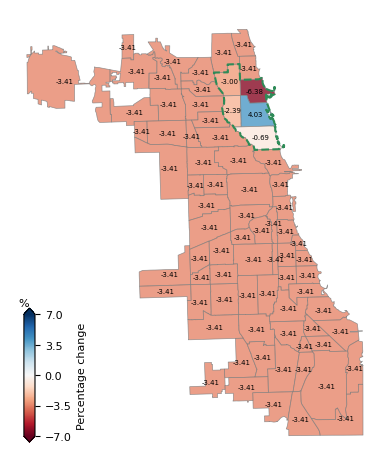

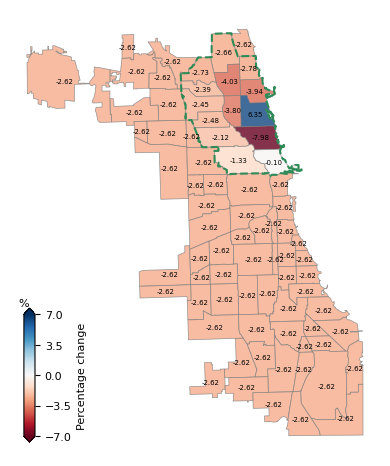

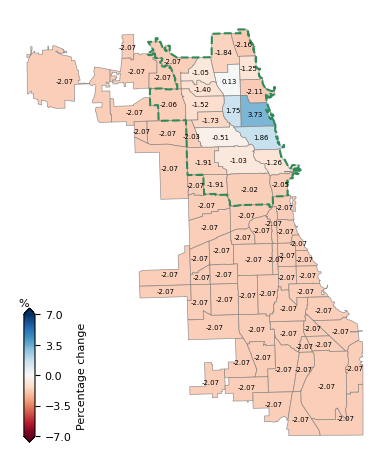

In [98]:
# 5, 330, value, 0.1
# 5, 349, value, 0.1
comm_id = 5
# set hh_id as the individual with the highest choice probability
data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False
)
x, y = next(iter(data_loader))
p = gnn2(x).exp().detach().numpy()
hh_id = np.argmax(p[:, comm_id])
# hh_id = 330
print(hh_id)  # 349
feature = "h_units_scaled"
# feature = "med_value_scaled"

vmax=7
vmin=-7
f1 = plot_elasticity(
    gnn1, comm_id=comm_id, hh_id=hh_id, percent_change=0.1, feature=feature, boundary=get_boundary(comm_id, 1), vmax=vmax, vmin=vmin
)
f2 = plot_elasticity(
    gnn2, comm_id=comm_id, hh_id=hh_id, percent_change=0.1, feature=feature, boundary=get_boundary(comm_id, 2), vmax=vmax, vmin=vmin
)
f3 = plot_elasticity(
    gnn3, comm_id=comm_id, hh_id=hh_id, percent_change=0.1, feature=feature, boundary=get_boundary(comm_id, 3), vmax=vmax, vmin=vmin
)

In [99]:
f2.savefig("elasticity_gnn2.pdf")
f3.savefig("elasticity_gnn3.pdf")
# f1.set_tight_layout(tight=True)
f1.savefig("elasticity_gnn1.pdf")

/var/folders/v6/5jphmjb1409bj0_xw7mj_7dc0000gn/T/ipykernel_10358/2365022011.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


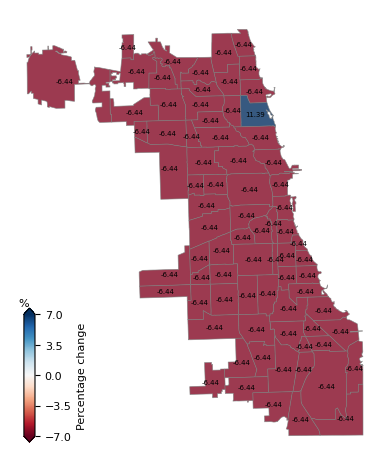

In [100]:
f_mnl = plot_elasticity(mnl, comm_id=comm_id, hh_id=hh_id, percent_change=0.1, feature=feature, vmax=7, vmin=-7)
f_mnl.savefig("elasticity_mnl.pdf")